# __<center> Projet Maths-info #1 : Lignes de niveau</center>__

Binôme: Julien LAVAL et Nathan LINÉ.

Ce notebook développe un programme Python pour le calcul de ligne de niveau d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$, qui est $\mathcal{C}^1$.

Tout d'abord, on import les librairies Python dont on aura besoin :

In [3]:
import autograd 
from autograd import numpy as np
import matplotlib.pyplot as plt

#### Fonctions de test :

Pour tester les différents algorithmes de ce notebook, on définit dès lors plusieurs fonctions test de $\mathbb{R}^2$ dans $\mathbb{R}$ :

In [4]:
def quad(x,y):
    #Fonction quadratique
    return x**2+y**2

def l(x,y):
    # Fonction utilisée pour la démo de la fonction contour de matplotlib
    return 2*(np.exp(-x**2 -y**2) - np.exp(-(x-1)**2-(y-1)**2))
           

### Contour simple :

Dans un premier temps, on suppose $f: [0,1]^2 \to \mathbb{R}$, et on cherche des lignes de niveaux qui ont un point sur l'arrête gauche.

#### **Amorce :**

$\triangleright$ Condition pour avoir un point sur l'arrête gauche:  
Soit $c \in \mathbb{R}$.  
Si $c \in [f(0,0), f(0,1)]$, comme $f$ est $\mathcal{C}^1$, donc a fortiori continue, il existe par TVI $ t \in [0,1]$ tel que $f(0,t) = c$.  
Cette condition se réécrit $(f(0,0) - c)(f(0,1) -c) \leq 0$, forme plus manipulable en pratique ( car pas besoin de tester d'inégalité entre $f(0,0)$ et $f(0,1)$).

$\underline{Remarque:}$ Cette condition est *suffisante*, mais évidemment pas *nécessaire*. Elle restreint donc trop grandement la classe de fonction traitée, mais suffira ici.


$\triangleright$ Pour plus de lisibilité, on définit $h : [0,1] \to \mathbb{R}, \; t  \mapsto f(0,t) - c$ : la condition devient $h(0).h(1) \leq 0$.  
On code alors la fonction *find_seed*:

In [13]:
def find_seed(f, c=0, eps= 2**(-26)):
    # Dichotomie sur la taille de l'intervalle pour trouver le réel en question.
    #La taille de l'intervalle étant divisé par 2 à chaque tour de la boucle while, la terminaison est assurée.
    def h(t):
        return (f(0,t) -c)
    if h(0) * h(1) > 0:
        return None
    i,j = 0,1
    while (j-i)>eps:
        t = (i+j)/2
        if h(i)*h(t)<=0:
            j = t
        else:
            i = t
    return i


#Vérification : 
#c = 1/4, avec la fonction quad, la valeur théorique est t = 1/2.

find_seed(quad, c = 1/4)
abs(find_seed(quad, c = 1/4)-1/2)<=2**(-26) 

True

#### Propagation :

**Méthode #1: Gradient**

Pour une fonction $f : \mathbb{R}^2 \to \mathbb{R}$ différentiable, la relation $df = \vec{\text{grad}}(f) \cdot dl$ implique que le gradient de $f$ est perpendiculaire aux lignes de niveaux.  
On peut donc procéder ainsi :
* On trouve un point de la ligne de niveau avec *find_seed*.
* On calcule ensuite son gradient, puis la droite perpendiculaire à ce gradient passant par ce point : elle approxime localement la ligne de niveau.
* Avec un pas suffisament faible, on suit cette ligne pour trouver le prochain point, puis on recommence.

Problèmes : 
* Le pas doit être suffisament faible pour que l'approximation soit légitime.
* En suivant la droite, il existe deux directions possibles : il faut *faire un choix*, et éviter de revenir sur ses pas.       

Calculs :  
$\triangleright$ Soit $z_0 = (x_0,y_0)$ point de $\mathbb{R}^2$, qui est la valeur dont on part.  
On note $\vec{\text{grad}}(f)(z_0) = \begin{pmatrix}a\\b\end{pmatrix}$, noté $G$ dans la suite.  
Soit $\mathcal{D}$ la droite perpendiculaire à $G$ et passant par $z_0$.
\begin{array}{rcl}
M = (x,y) \in \mathcal{D}   & \Leftrightarrow & \vec{M_0M} \perp G \\
              & \Leftrightarrow & \begin{pmatrix}x-x_0 \\ y - y_0 \end{pmatrix} \cdot \begin{pmatrix}a\\b\end{pmatrix}  = 0\\ 
              & \Leftrightarrow & a\,(x-x_0) + b\,(y-y_0) =0\\
\end{array}  

$\triangleright$ On impose également un pas de $\Delta$ entre les points, on a donc le système :  

\begin{array}{rl}
a\,(x-x_0) + b\,(y-y_0) =0 & (1) \\
(x-x_0)^2 + (y-y_0)^2 = \Delta^2 & (2) \\
\end{array}

$\bullet \, \underline{b = 0} : \, a \neq$ 0, et alors $(x,y) = (x_0, \,  y_0 \pm  \Delta) \quad \tiny{(\Delta \text{ positif})}$

$\bullet \, \underline{b \neq 0} : \, (2): \, (x-x_0)^2 (1+ (\dfrac{a}{b})^2) = \Delta^2$.  
$ \Rightarrow (x,y) = \left (x_0 \pm \dfrac{\Delta}{\sqrt{1+ (\frac{a}{b})^2}}, y_0 \mp \frac{a}{b} \dfrac{\Delta}{\sqrt{1+(\frac{a}{b})^2})} \right ) \quad \tiny{(\text{le } \pm \text{ et } \mp \text{ signifie que si l'on prend plus pour x, on prend moins pour y})}$.  
  
On se retrouve bien, comme prévu, avec deux couples solutions, donc deux directions possibles sur la droite. En choisissant toujours le même sens (par défaut, vers la droite), on obtient la fonction *simple_contour* suivante:

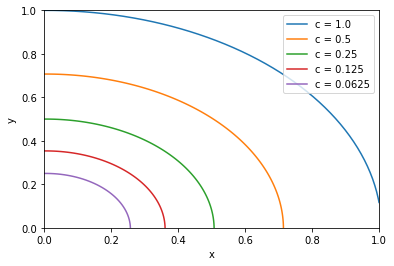

In [6]:
## Fonction gradient : 
def grad(f,x,y):
    g = autograd.grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

def simple_contour(f, c=0.0, delta = 0.01):
    x,y = [],[]
    if find_seed(f,c) != None:
        t = find_seed(f,c)
        x.append(0.0)
        y.append(t)
        [a,b] = grad(f,0.0,t)
        while (0<=x[-1]<=1) and (0<=y[-1]<=1):
            # On teste pour rester dans le carré.
            x_0, y_0 = x[-1], y[-1]
            # On implémente exactement le calcul précédent :
            if b !=0:
                x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        return x,y
    return [],[]

# Test sur la fonction quadratique, sur [0,1]².
for i in range(5):
    x_i,y_i = simple_contour(quad, (1/2)**i)
    plt.plot(x_i,y_i, label = f"c = {(1/2)**i}")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

$\underline{\textbf{Remarque : Théorème des fonctions implicites}} :$  
Avec $f: [0,1]^2 \to \mathbb{R} \; \mathcal{C}^1$, on note toujours $\vec{grad}(f) = (a,b)$.

Le théorème des fonctions implicites donne : 
Sur un voisinage sur lequel $\partial_yf$ est inversible, $f(x,y) = 0 \Leftrightarrow y = \psi(x)$.  
et $\psi'(x) = -(\partial_yf(x,y))^{-1} \partial_xf(x,y)  
             = -\dfrac{a}{b}$.

Ainsi, on peut localement écrire $y = \psi(x) \simeq - \dfrac{a}{b} (x-x_0) + y_0.$  
On retrouve $a(x-x_0) + b(y - y_0) = 0$ : la méthode est $\underline{équivalente}$. 
  


**Méthode #2: Dichotomie sur le cercle**

On considère toujours une fonction $f : [0,1]^2 \to \mathbb{R} \; \mathcal{C}^1$, et un pas $\Delta$ entre les points.  
L'algorithme suivant repose sur des dichotomies sur des cercles de rayon $\Delta$:
* On trouve un point de la ligne de niveau avec *find_seed*.
* On trace un cercle de rayon $\Delta$ autour du point, et on effectue une dichotomie sur le cercle afin de trouver le prochain point. La dichotomie est seulement effectuée sur une moitié du cercle, définie par la direction.
* On recommence jusqu'à sortir du cadre $[0,1]^2$.



In [7]:
# Une dichotomie sur une fonction : 
def dichotomie(f,c,a,b,eps = 2**(-26)):
    def h(t):
        return(f(t)-c)   
    while (b-a) > eps:
        k = (a+b)/2
        if h(a)*h(k) < 0:
            b = k
        else:
            a = k
    return(a)


def simple_contour_2(f, c = 0.0, delta = 0.01): 
    x,y = [],[]
    direction = 0
    if find_seed(f,c) != None:
        t = find_seed(f,c)
        x.append(0.0)
        y.append(t)
        t0 = 0
        while (0<=x[-1]<=1) and (0<=y[-1]<=1) and np.pi/2 - t0 >= 2**(-26): 
        # le dernier test permet de quitter la boucle si y a pas de solution à la dichotomie : la ligne de niveau s'arrête.
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        return x,y
    return [],[]

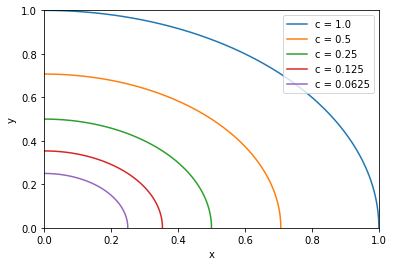

In [8]:
# Test sur la fonction quadratique, sur [0,1].
for i in range(5):
    x_i,y_i = simple_contour_2(quad, (1/2)**i)
    plt.plot(x_i,y_i, label = f"c = {(1/2)**i}")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

$\underline{Commentaire} :$ Le programme ne marche pas pour tout type de fonctions, puisque l'on peut imaginer des fonctions avec des lignes niveaux formant des angles aigus. On peut alors effectuer la dichotomie sur une portion plus grande du cercle - *mais jamais tout le cercle, pour ne pas revenir en arrière* - mais on pourra toujours construire des fonctions qui ne marchent pas, pour une portion donnée.  
Cependant, pour une fonction donnée, on peut alors construire une portion de cercle qui marche.  
  
De plus, le pas $\Delta$ pouvant être choisi très faible, les problèmes de rebroussement peuvent être gérés.

### Contour complexe :

On suppose maintenant que $f$ n'est plus définie sur $[0,1]^2$, mais sur un rectangle borné de $\mathbb{R}^2$.  
On généralise les fonctions précédentes et on divise le domaine en carrés pour les appliquer.

* Les fonctions de recherche de seed des quatres côtés :

In [25]:
def find_seed_gauche(f, c, xmin, ymin, ymax, eps = 2**(-26)):
    def h(t):
        return(f(xmin,t)-c)
    if h(ymin)*h(ymax) > 0:
        return None
    else:
        i,j = ymin,ymax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

def find_seed_droite(f, c, xmax, ymin, ymax, eps = 2**(-26)):
    def h(t):
        return(f(xmax,t)-c)
    if h(ymin)*h(ymax) > 0:
        return None
    else:
        i,j = ymin,ymax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i
    
def find_seed_bas(f, c, xmin, xmax, ymin, eps = 2**(-26)):
    def h(t):
        return(f(t,ymin)-c)
    if h(xmin)*h(xmax) > 0:
        return None
    else:
        i,j = xmin,xmax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

def find_seed_haut(f, c, xmin, xmax, ymax, eps = 2**(-26)):
    def h(t):
        return(f(t,ymax)-c)
    if h(xmin)*h(xmax) > 0:
        return None
    else:
        i,j = xmin,xmax
        while (j-i) > eps:
            k = (i+j) / 2
            if h(k)*h(j) > 0:
                j = k
            else:
                i = k
    return i

Remarque : On peut éviter de coder 4 fonctions en procédant à une rotation, mais le résultat est le même.

**Méthode #2: Dichotomie sur cercles**


* Une fonction *simple_contour_annexe* adaptée aux nouveaux contours variables, et à la recherche de seed sur 4 côtés.

In [26]:
def simple_contour_annexe(f, xmin, xmax, ymin, ymax, c, delta):
    x,y = [],[]
    lx,ly = [],[]
    direction = 0
    # Ici, une disjonction de cas sur le bord, donc 4 blocs assez similaires.
    if find_seed_gauche(f, c, xmin, ymin, ymax) != None:
        t = find_seed_gauche(f, c, xmin, ymin, ymax)
        x.append(xmin)
        y.append(t)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            # le dernier test permet de quitter la boucle si y a pas de solution à la dichotomie : la ligne de niveau s'arrête.
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                # fonction f sur le cercle autour de (x0,y0)
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = x, y
    x,y = [],[]
    direction = np.pi
    if find_seed_droite(f, c, xmax, ymin, ymax) != None:
        t = find_seed_droite(f, c, xmax, ymin, ymax)
        x.append(xmax)
        y.append(t)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            x0 = x[-1]
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly= lx + x, ly + y
    x,y = [],[]
    direction = np.pi/2
    if find_seed_bas(f, c, xmin, xmax, ymin) != None:
        t = find_seed_bas(f, c, xmin, xmax, ymin)
        x.append(t)
        y.append(ymin)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)): 
            x0 = x[-1] 
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = lx + x, ly + y
    x,y = [],[]
    direction = -np.pi/2
    if find_seed_haut(f, c, xmin, xmax, ymax) != None:
        t = find_seed_haut(f, c, xmin, xmax, ymax)
        x.append(t)
        y.append(ymax)
        t0 = 0
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax) and (np.pi/2 - t0 >= 2**(-26)):
            x0 = x[-1]
            y0 = y[-1]
            def h(t):
                return(f(x0+delta*np.cos(t+direction),y0+delta*np.sin(t+direction)))
            t0 = dichotomie(h,c,-np.pi/2,np.pi/2,2**(-26))
            direction += t0
            x.append(x0 + delta*np.cos(direction))
            y.append(y0 + delta*np.sin(direction))
        lx, ly = lx + x, ly + y
    return (lx,ly)

* La fonction *contour* finale :

In [27]:
def contour(f, xc = [0.0,1.0], yc = [0.0,1.0], c = 0.0, delta = 0.01):
    xs, ys = [], []
    n, m = len(xc), len(yc)
    for i in range(n-1):
        for j in range(m-1):
            xmin = xc[i]
            xmax = xc[i+1]
            ymin = yc[j]
            ymax = yc[j+1]
            lx,ly = simple_contour_annexe(f,xmin,xmax,ymin,ymax,c,delta)
            xs.append(lx)
            ys.append(ly)
    for x,y in zip(xs,ys):
        plt.plot(x,y)

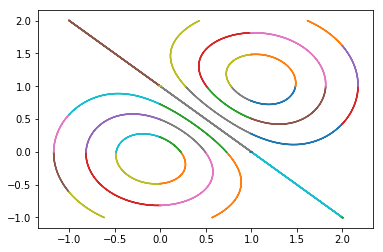

In [28]:
# Test avec la fonction l(x,y)

xc = [-2.0,-1.0,0.0,1.0,2.0,3.0]
yc = [-1.0,0.0,1.0,2.0]

contour(l,xc,yc,0.0)
contour(l,xc,yc,0.5)
contour(l,xc,yc,1.0)
contour(l,xc,yc,1.5)  
contour(l,xc,yc,-0.5)
contour(l,xc,yc,-1.0)
contour(l,xc,yc,-1.5)

Le résultat est bien celui voulu, avec une complexité relativement faible.  
\+ commentaire /comparaison

**Méthode #1: Gradient**

* A nouveau, une fonction *simple_contour_annexe_2* avec la méthode du gradient : 

In [29]:
#Distance pour comparer
def d(x,y,z,t):
    return (x-z)**2 + (y-t)**2


def simple_contour_annexe_2(f, xmin, xmax, ymin, ymax, c, delta):
    lx, ly= [], []
    x,y = [],[]
    # Disjonction de cas sur les quatres bords.
    if find_seed_gauche(f, c, xmin, ymin, ymax) != None:
        t = find_seed_gauche(f, c, xmin, ymin, ymax)
        x.append(xmin)
        y.append(t)
        [a,b] = grad(f,xmin,t)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = x, y
    x, y = [],[]
    if find_seed_droite(f, c, xmax, ymin, ymax) != None:
        t = find_seed_droite(f, c, xmax, ymin, ymax)
        x.append(xmax)
        y.append(t)
        [a,b] = grad(f,xmax,t)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y
    x, y = [],[]
    if find_seed_bas(f, c, xmin, xmax, ymin) != None:
        t = find_seed_bas(f, c, xmin, xmax, ymin)
        x.append(t)
        y.append(ymin)
        [a,b] = grad(f,t,ymin)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y
    x, y = [],[]
    if find_seed_haut(f, c, xmin, xmax, ymax) != None:
        t = find_seed_haut(f, c, xmin, xmax, ymax)
        x.append(t)
        y.append(ymax)
        [a,b] = grad(f,t,ymax)
        while (xmin <= x[-1] <= xmax) and (ymin <= y[-1] <= ymax):
            x_0,y_0 = x[-1],y[-1]
            if b !=0:
                if len(x)>=2:
                    xp, yp = x[-2],y[-2]
                    x1,x2 = x_0 + delta/np.sqrt((1 + (a/b)**2)), x_0 - delta/np.sqrt((1 + (a/b)**2))
                    y1,y2 = -a/b*(x1 - x_0) + y_0, -a/b*(x2 - x_0) + y_0
                    if d(x1,y1,xp,yp) >= d(x2,y2,xp,yp):
                        x.append(x1)
                        y.append(y1)
                    else:
                        x.append(x2)
                        y.append(y2)
                else:
                    x.append(x_0 + delta/np.sqrt((1 + (a/b)**2)))
                    y.append(-a/b*(x[-1] - x_0) + y_0)
            else:
                x.append(x_0)
                y.append(y_0 + delta)
            [a,b] = grad(f,x[-1],y[-1])
        lx, ly = lx + x, ly + y 
        
    return (lx,ly)

* La fonction *contour* finale : 

In [30]:
def contour_2(f, xc = [0.0,1.0], yc = [0.0,1.0], c = 0.0, delta = 0.01):
    xs, ys = [], []
    n, m = len(xc), len(yc)
    for i in range(n-1):
        for j in range(m-1):
            xmin = xc[i]
            xmax = xc[i+1]
            ymin = yc[j]
            ymax = yc[j+1]
            lx, ly = simple_contour_annexe_2(f,xmin,xmax,ymin,ymax,c,delta)
            xs.append(lx)
            ys.append(ly)
    for x,y in zip(xs,ys):
        plt.plot(x,y,'.',color='r', markersize=2)

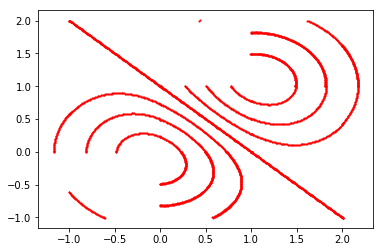

In [33]:
# Test avec la fonction l(x,y)

xc = [-2.0,-1.0,0.0,1.0,2.0,3.0]
yc = [-1.0,0.0,1.0,2.0]

contour_2(l,xc,yc,0.0)
contour_2(l,xc,yc,0.5)
contour_2(l,xc,yc,1.0)
contour_2(l,xc,yc,1.5)  
contour_2(l,xc,yc,-0.5)
contour_2(l,xc,yc,-1.0)
contour_2(l,xc,yc,-1.5)